<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Change Inputs Here

In [19]:
task = "months"  # choose: numerals, numwords, months
# prompt_types = ['done', 'lost', 'names']
prompt_types = ['lost']
# num_samps_per_ptype = 128 #768 512
num_samps_per_ptype = 1 # 12 #768 512

model_name = "gpt2-small"

save_files = True

# Setup

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle

In [15]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-_0c_csbk
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-_0c_csbk
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 318236402ddcc9cabace3f2fca40c71f0c2e9e57
  Installing build dependencies ... canceledERROR: Operation cancelled by user


In [16]:
from transformer_lens import HookedTransformer
import torch
torch.set_grad_enabled(False)  # turn automatic differentiation off

In [17]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/attn_pats

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 1022 (delta 296), reused 378 (delta 190), pack-reused 534
Receiving objects: 100% (1022/1022), 18.76 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (659/659), done.
/content/seqcont_circuits/src/attn_pats


In [18]:
from viz_attn_pat import *

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [9]:
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [11]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# small Dataset

In [ ]:
# def generate_prompts_list(x ,y):
#     prompts_list = []
#     for i in range(x, y):
#         prompts_list.append(f"{i} {i+1} {i+2} {i+3}")
#     return prompts_list

# prompts = generate_prompts_list(10, 17)
# prompts

['10 11 12 13',
 '11 12 13 14',
 '12 13 14 15',
 '13 14 15 16',
 '14 15 16 17',
 '15 16 17 18',
 '16 17 18 19']

In [ ]:
# tokens = model.to_tokens(prompts, prepend_bos=True)
# # tokens = tokens.cuda() # Move the tokens to the GPU

# # get the cache to get attention patterns from
# original_logits, local_cache = model.run_with_cache(tokens) # Run the model and cache all activations

# Dataset

In [20]:
prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circuits/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    # change this to less if have CUDA have out of memory issues
    prompts_list += filelist [:num_samps_per_ptype] #768 512 256 128

prompts = [prompt['text'] for prompt in prompts_list]
print(len(prompts))

1


In [23]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU

# get the cache to get attention patterns from
original_logits, local_cache = model.run_with_cache(tokens) # Run the model and cache all activations

In [24]:
import gc

del(original_logits)
# del(local_cache)
torch.cuda.empty_cache()
gc.collect()

0

# Functions

## viz

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pdb

def get_ind(token_list, token1, token2, printInd=False):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        if printInd:
            print(f"The index of '{token1}' is {query_ind}")
            print(f"The index of '{token2}' is {key_ind}")
    return query_ind, key_ind

def viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_index,
    task = 'numerals', # choose: numerals, numwords, months
    highlightLines = '',  # early, mid, late, ''
    savePlotName = ''
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    # local_tokens = tokens[-1] # last sample uses names
    local_tokens = tokens[0] # first sample has 1 2 3 4
    str_tokens = model.to_str_tokens(local_tokens)
    str_tokens[0] = '<PAD>' # Rename the first token string as '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold', labelpad=20)
    ax.set_ylabel('Query', fontsize=16, fontweight='bold', labelpad=20)

    # choose tokens to display
    if task == 'numerals':
        disp_toks = [" 4", " 3", " 2", " 1"]
    elif task == 'numwords':
        disp_toks = [" four", " three", " two", " one"]
    elif task == 'months':
        disp_toks = ["April", "March", "February", "January"]
        # disp_toks = [" Apr", " Mar", " Feb", " Jan"]

    if highlightLines != '':
        if highlightLines == 'early':
            token_pairs_highL = [(disp_toks[-2], disp_toks[-1]), (disp_toks[-3], disp_toks[-2]), (disp_toks[-4], disp_toks[-3])]
            # token_pairs_highL = [(" 2", " 1"), (" 3", " 2"), (" 4", " 3")]
        elif highlightLines == 'mid':
            last_token = str_tokens[-1]
            token_pairs_highL = [(last_token, disp_toks[-2]), (last_token, disp_toks[-3]), (last_token, disp_toks[-4])]
            # token_pairs_highL = [(last_token, ' 2'), (last_token, ' 3'), (last_token, ' 4')]
        elif highlightLines == 'late':
            last_token = str_tokens[-1]
            token_pairs_highL = [(last_token, disp_toks[-4])]
            # token_pairs_highL = [(last_token, ' 4')]

        for qk_toks in token_pairs_highL:
            qInd, kInd = get_ind(str_tokens, qk_toks[0], qk_toks[1])
            if highlightLines != 'early':  # do this if last token has multiple repeats
                qInd = len(str_tokens) - 1  # or else it'd get the first repeat
            plt.plot([0, kInd+1], [qInd, qInd], color='#7FFF00', linewidth=5)  # top of highL row
            plt.plot([kInd+1, kInd+1], [qInd, len(str_tokens)], color='blue', linewidth=5)  # right of highL col

            yticklabels = ax.get_yticklabels()
            yticklabels[qInd].set_color('green')
            yticklabels[qInd].set_fontweight('bold')
            yticklabels[qInd].set_fontsize(14)
            ax.set_yticklabels(yticklabels)
            xticklabels = ax.get_xticklabels()
            xticklabels[kInd].set_color('blue')
            xticklabels[kInd].set_fontweight('bold')
            xticklabels[kInd].set_fontsize(14)
            ax.set_xticklabels(xticklabels)

        # offset pattern for prev token heads
        # if highlightLines == 'mid':
            # for i in range(0, len(str_tokens)-1):
                #     rect = patches.Rectangle((i, i+4), 1, 1, linewidth=4.5, edgecolor='#3CB371', facecolor='none')
                #     ax.add_patch(rect)

    if savePlotName != '':
        # file_name = f'new_results/savePlotName + '.png'
        # directory = os.path.dirname(file_name)
        # if not os.path.exists(directory):
        #     os.makedirs('new_results', exist_ok=True)
        plt.savefig(savePlotName + '.png', bbox_inches='tight')

    plt.show()

## Index attn pat fns

In [26]:
# Tokenized sentence is stored in token_list and the tokens you are interested in are token1 and token2
token1 = "March"
token2 = "February"

local_tokens = tokens[0]
token_list = model.to_str_tokens(local_tokens)

In [27]:
def get_attn_val(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at "{token1}" "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val(token_list, token1, token2, 4, 4)

The avg heatmap value at "March" "February" is 0.012510189786553383 for 4.4


In [28]:
def get_attn_val_fromEnd(token_list, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = -1
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        # print(f"The index of '{token1}' is {query_ind}")
        # print(f"The index of '{token2}' is {key_ind}")

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at last token to "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val_fromEnd(token_list, token1, 9, 1)
get_attn_val_fromEnd(token_list, token2, 9, 1)

The avg heatmap value at last token to "March" is 0.00010382130858488381 for 9.1
The avg heatmap value at last token to "February" is 0.00013767604832537472 for 9.1


In [29]:
get_ind(token_list, token1, token2, printInd=True)

The index of 'March' is 15
The index of 'February' is 10


(15, 10)

# Early heads

## Number Detection/Similar Type Heads

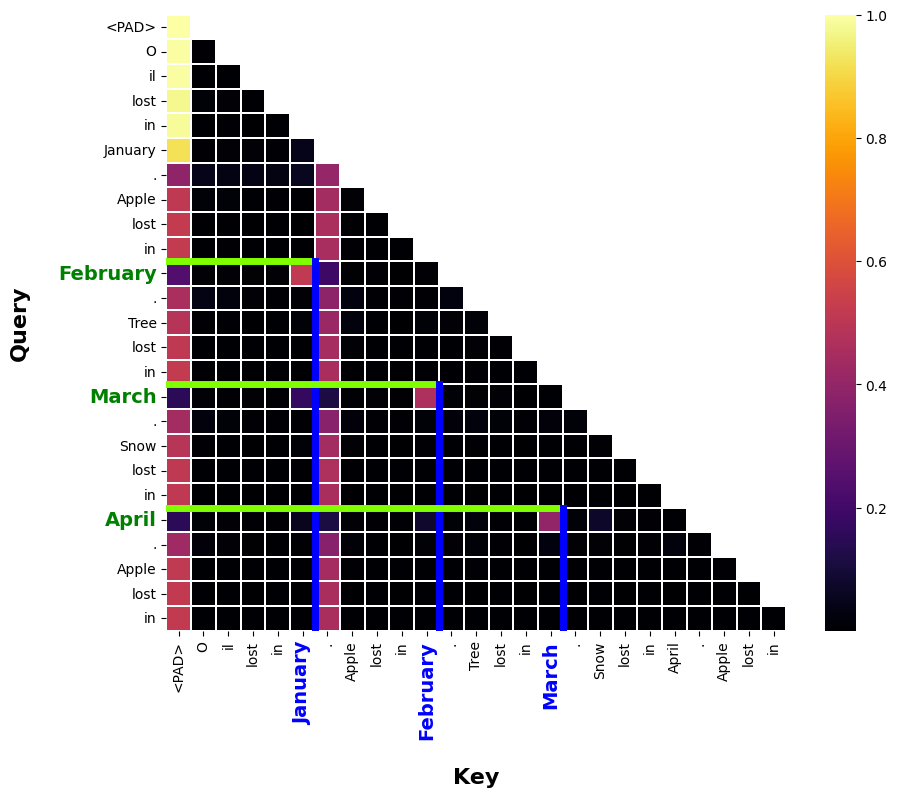

In [ ]:
layer = 5
head_ind = 25
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

Lighter/Warmer "sunnier" colors mean higher attention values.


## Duplicate Heads

In [ ]:
def viz_attnPat_dupl(
    layer, head_index,
    highlightLines = True
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = model.to_str_tokens(tokens[0])
    str_tokens[0] = '<END>' # Rename the first token string as '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        for i in range(0, 19):
            rect = patches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((i, i+4), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((i, i+9), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()

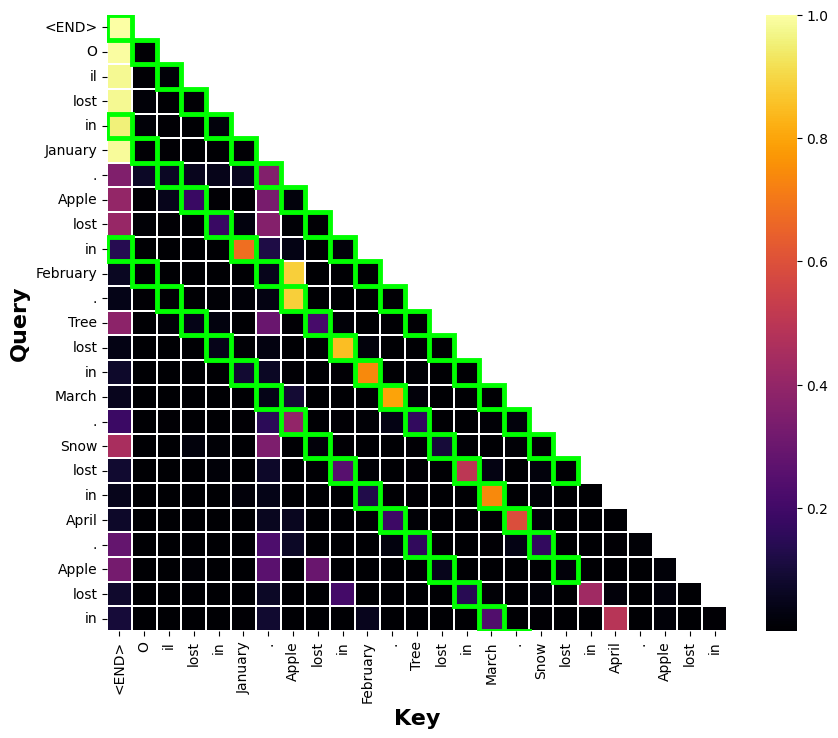

In [ ]:
viz_attnPat_dupl(layer = 6, head_index = 11)

# Middle heads

Notice the last token in the sequence (last row) pays attention to the most recent seq members.

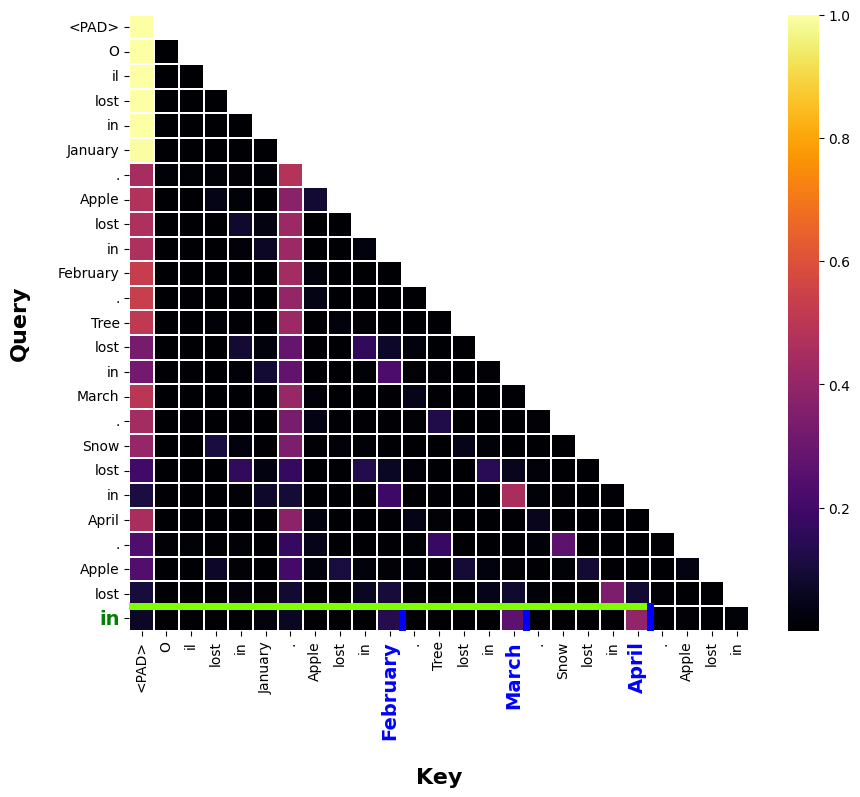

In [ ]:
layer = 11
head_ind = 18
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'mid',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

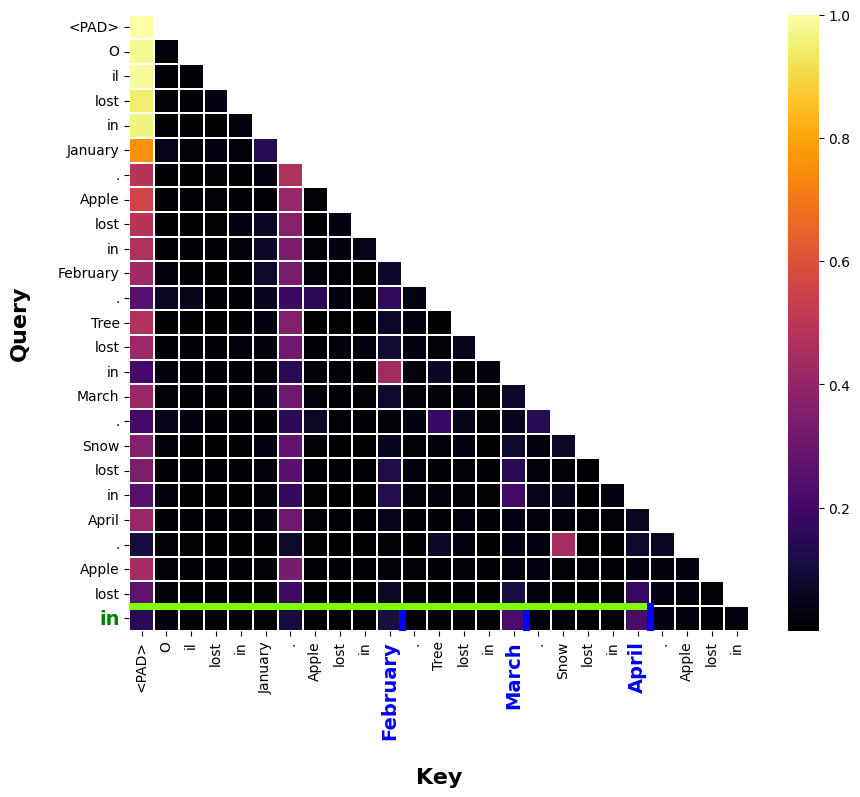

In [30]:
layer = 16
head_ind = 0
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'mid',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

This pays attention to all numbers except the first seq member; albeit, not that strong for each. More recent seq members are stronger.

# Late heads

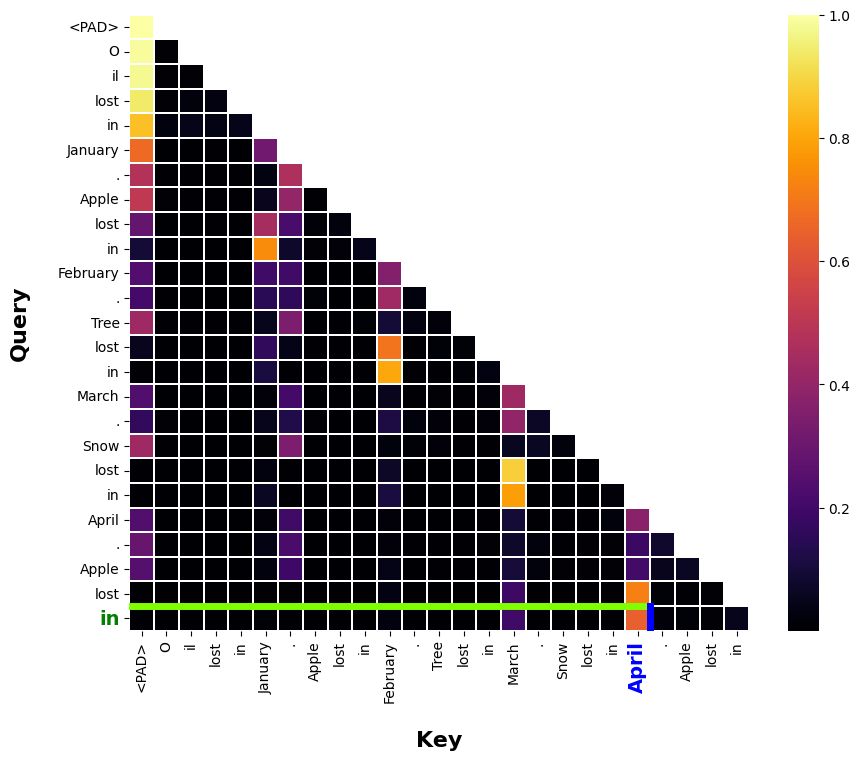

In [ ]:
layer = 20
head_ind = 17
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    task,
    highlightLines = 'late',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

The last row (token) pays attention a lot to ONLY the most recent number token.

# Download files from nb

In [ ]:
from google.colab import files
if save_files:
    for layer, head_ind in [(1,5), (4,4), (7,11), (9,1)]:
        savePlotName = f'attnpat{layer}_{head_ind}_{task}'
        files.download(savePlotName + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>